<a href="https://colab.research.google.com/github/dari99919/TFG-Inteligencia/blob/main/c%C3%B3digo_TFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
from datetime import datetime

# Desactivar advertencias
warnings.filterwarnings('ignore')

# =================================================================
# 1. PORTAFOLIO Y FILTRADO DE ACTIVOS
# =================================================================
# Eliminamos "GOOG" para evitar duplicidad con "GOOGL" (Clase A vs Clase C)
# También mantenemos los activos que dan error en la descarga
excluded_tickers = ["GOOG", "ATVI", "CERN", "WBA", "SGEN", "SPLK", "ANSS", "WLTW"]

portfolio_raw = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA", "BRO",
    "AVGO", "COST", "PEP", "ADBE", "CSCO", "CMCSA", "NFLX", "TMO", "AMD",
    "QCOM", "INTC", "AMAT", "SBUX", "GILD", "INTU", "MDLZ", "ISRG", "ADI",
    "PYPL", "VRTX", "BKNG", "FISV", "REGN", "LRCX", "CHTR", "MU",
    "MNST", "KHC", "WDAY", "MAR", "MRNA", "ASML", "CSX", "KDP", "MCHP",
    "AEP", "SNPS", "XEL", "IDXX", "CTAS", "KLAC", "FAST", "EA",
    "ADSK", "BIDU", "CDNS", "ALGN", "DLTR", "SWKS", "BIIB",
    "SIRI", "NTES", "ILMN", "PCAR", "DXCM", "PAYX", "INCY", "MCO",
    "JD", "ROST", "EXC", "PINS", "ODFL", "CTSH", "HBAN", "VRSK",
    "FOX", "CBOE", "TTWO", "EBAY", "ZM", "FTNT", "MTCH", "OKTA",
    "CPRT", "MRVL", "PTON", "DDOG", "DOCU", "CZR", "ABNB", "ZBRA"
]

# Filtrar el portafolio eliminando los excluidos (incluyendo GOOG)
portfolio = [t for t in portfolio_raw if t not in excluded_tickers]

start_date = '2022-01-01'
end_date = '2025-01-01'
TARGET_YEARS = [2022, 2023, 2024]

# Contenedores
all_prices = pd.DataFrame()
all_dividends = pd.DataFrame()
fundamentales = {}
valoracion = {}
rentabilidad_fund = {}
yield_dic_2024 = {}

print(f"Iniciando proceso para {len(portfolio)} activos activos (Excluidos: {excluded_tickers})...")

# =================================================================
# PARTE 1: EXTRACCIÓN Y CÁLCULOS
# =================================================================

for ticker in portfolio:
    try:
        stock = yf.Ticker(ticker)

        # --- A. MERCADO ---
        hist = stock.history(start=start_date, end=end_date)
        if hist.empty:
            continue

        all_prices[ticker] = hist['Close']
        divs = stock.dividends
        all_dividends[ticker] = divs[(divs.index >= start_date) & (divs.index <= end_date)]

        # --- B. FUNDAMENTALES ---
        fin = stock.financials.T
        bs = stock.balance_sheet.T
        cf = stock.cashflow.T

        if fin.empty or bs.empty:
            print(f"Saltando {ticker}: Datos financieros insuficientes.")
            continue

        df_full = pd.concat([fin, bs, cf], axis=1)
        if not hasattr(df_full.index, 'year'):
            continue

        df_hist = df_full[df_full.index.year.isin(TARGET_YEARS)]

        for date, row in df_hist.iterrows():
            year = date.year
            fundamentales[(ticker, f"Net Income {year}")] = row.get('Net Income Common Stockholders', np.nan)
            fundamentales[(ticker, f"Total Revenue {year}")] = row.get('Total Revenue', np.nan)
            fundamentales[(ticker, f"EBITDA {year}")] = row.get('EBITDA', np.nan)
            fundamentales[(ticker, f"Free Cash Flow {year}")] = row.get('Free Cash Flow', np.nan)
            fundamentales[(ticker, f"Total Debt {year}")] = row.get('Total Debt', np.nan)
            fundamentales[(ticker, f"Capex {year}")] = row.get('Capital Expenditure', np.nan)
            fundamentales[(ticker, f"Total Assets {year}")] = row.get('Total Assets', np.nan)

            ebit = row.get('EBIT', np.nan)
            equity = row.get('Stockholders Equity', np.nan)
            debt = row.get('Total Debt', np.nan)
            fund_ni = row.get('Net Income Common Stockholders', 0)

            rentabilidad_fund[(ticker, f"ROE % {year}")] = (fund_ni / equity) * 100 if equity and equity != 0 else np.nan
            rentabilidad_fund[(ticker, f"ROA % {year}")] = (fund_ni / row.get('Total Assets', 1)) * 100
            rentabilidad_fund[(ticker, f"ROIC % {year}")] = (ebit / (equity + debt)) * 100 if (equity + debt) and (equity + debt) != 0 else np.nan

        # Valoración y Yield
        info = stock.info
        valoracion[ticker] = {
            'PER': info.get('trailingPE'),
            'Price to Sales': info.get('priceToSalesTrailing12Months'),
            'Price to Book': info.get('priceToBook')
        }

        divs_2024 = stock.dividends[stock.dividends.index.year == 2024].sum()
        price_end_2024 = hist['Close'].iloc[-1] if not hist.empty else np.nan
        yield_dic_2024[ticker] = {'Yield 31/12/2024 (%)': (divs_2024 / price_end_2024) * 100 if price_end_2024 > 0 else 0}

    except Exception as e:
        print(f"Error procesando {ticker}: {e}")

# =================================================================
# PARTE 2: ORGANIZACIÓN DE TABLAS Y EXCEL
# =================================================================

all_dividends = all_dividends.reindex(all_prices.index, fill_value=0)
daily_returns = (all_prices - all_prices.shift(1) + all_dividends) / all_prices.shift(1)
daily_returns = daily_returns.dropna(how='all')

all_prices.index = all_prices.index.strftime('%Y-%m-%d')
all_dividends.index = all_prices.index
daily_returns.index = daily_returns.index.strftime('%Y-%m-%d')

df_fund_final = pd.Series(fundamentales).unstack().sort_index(axis=1)
df_rent_fund_final = pd.Series(rentabilidad_fund).unstack().sort_index(axis=1)
df_val_final = pd.DataFrame.from_dict(valoracion, orient='index')
df_yield_final = pd.DataFrame.from_dict(yield_dic_2024, orient='index')

nombre_archivo = "Analisis_Financiero_Filtrado_2022_2024.xlsx"
with pd.ExcelWriter(nombre_archivo) as writer:
    all_prices.to_excel(writer, sheet_name='01_Precios_Cierre')
    all_dividends.to_excel(writer, sheet_name='02_Dividendos_Efectivos')
    daily_returns.to_excel(writer, sheet_name='03_Rentabilidad_Total_Diaria')
    df_fund_final.to_excel(writer, sheet_name='04_Fundamentales_Anuales')
    df_rent_fund_final.to_excel(writer, sheet_name='05_Ratios_Rentabilidad')
    df_val_final.to_excel(writer, sheet_name='06_Ratios_Valoracion')
    df_yield_final.to_excel(writer, sheet_name='07_Yield_Final_2024')

print(f"\n✅ Archivo generado: {nombre_archivo}")

Iniciando proceso para 90 activos activos (Excluidos: ['GOOG', 'ATVI', 'CERN', 'WBA', 'SGEN', 'SPLK', 'ANSS', 'WLTW'])...

✅ Archivo generado: Analisis_Financiero_Filtrado_2022_2024.xlsx


In [48]:
# =================================================================
# EXPECTED VALUE AND RISK (Análisis Estadístico Actualizado)
# =================================================================
import pandas as pd
import numpy as np

# 1. Parámetros para anualizar
trading_days = 252
rf = 0.02 # Tasa libre de riesgo asumida (2%) para el Sharpe individual

# 2. Limpieza de seguridad
# Eliminamos activos que puedan haber quedado con NaN tras el filtrado de GOOG u otros errores
returns_clean = daily_returns.dropna(axis=1, how='all')

# 3. Calcular rendimiento esperado anualizado
# Rendimiento = Media diaria * 252
expected_returns = returns_clean.mean() * trading_days

# 4. Calcular riesgo anualizado (volatilidad)
# Riesgo = Desviación estándar diaria * raíz(252)
risk = returns_clean.std() * np.sqrt(trading_days)

# 5. Crear DataFrame con estadísticas de cada activo
assets_stats = pd.DataFrame({
    "Rendimiento_Anual_Esperado": expected_returns,
    "Riesgo_Anual": risk,
    "Sharpe_Ratio_Individual": (expected_returns - rf) / risk
})

# 6. Ordenar por rendimiento esperado (De mayor a menor)
assets_stats = assets_stats.sort_values(by="Rendimiento_Anual_Esperado", ascending=False)

# 7. Guardar en Excel
output_stats_file = "Estadisticas_Activos_2022_2024.xlsx"
assets_stats.to_excel(output_stats_file, sheet_name="Asset_Stats")

print(f"✅ Estadísticas calculadas para {len(assets_stats)} activos.")
print(f"Archivo guardado: {output_stats_file}")

# 8. Mostrar los 10 mejores activos por Rendimiento
print("\nTop 10 activos por Rendimiento Esperado:")
display(assets_stats.head(10))

✅ Estadísticas calculadas para 90 activos.
Archivo guardado: Estadisticas_Activos_2022_2024.xlsx

Top 10 activos por Rendimiento Esperado:


,Rendimiento_Anual_Esperado,Riesgo_Anual,Sharpe_Ratio_Individual
NVDA,0.639860,0.553828,1.119227
AVGO,0.496865,0.423587,1.125777
META,0.327812,0.490159,0.627985
NFLX,0.305981,0.492304,0.580902
BKNG,0.299915,0.323292,0.865827
FISV,0.264140,0.238596,1.023236
PCAR,0.248393,0.252716,0.903751
MAR,0.240276,0.284395,0.774544
MRVL,0.228413,0.588157,0.354349
CDNS,0.228244,0.350342,0.594402


In [49]:
# =================================================================
# MATRIZ DE COVARIANZA Y CORRELACIONES (Ajustada)
# =================================================================
import pandas as pd
import numpy as np

# Usamos 'returns_clean' generado en el bloque estadístico anterior
# 1. Matriz de correlación
# Mide la relación lineal entre activos. Crucial para la diversificación.
correlation_matrix = returns_clean.corr()

print(f"Matriz de correlación para {len(correlation_matrix)} activos (Muestra 10x10):")
display(correlation_matrix.iloc[:10, :10])

# 2. Matriz de covarianza anualizada
# Es el motor del riesgo de la cartera. Se anualiza multiplicando por 252.
trading_days = 252
covariance_matrix = returns_clean.cov() * trading_days

print("\nMatriz de covarianza anualizada (Muestra 10x10):")
display(covariance_matrix.iloc[:10, :10])

# 3. Guardar en Excel
output_matrices_file = "Matrices_Correlacion_Covarianza_2022_2024.xlsx"
with pd.ExcelWriter(output_matrices_file) as writer:
    correlation_matrix.to_excel(writer, sheet_name="Correlacion")
    covariance_matrix.to_excel(writer, sheet_name="Covarianza")

print(f"\n✅ Matrices calculadas y guardadas en: {output_matrices_file}")

Matriz de correlación para 90 activos (Muestra 10x10):


,AAPL,MSFT,GOOGL,AMZN,NVDA,META,TSLA,BRO,AVGO,COST
AAPL,1.000000,0.687482,0.624747,0.576878,0.557329,0.503377,0.503259,0.455712,0.494855,0.517381
MSFT,0.687482,1.000000,0.692946,0.697311,0.636697,0.593994,0.425334,0.432631,0.512828,0.512752
GOOGL,0.624747,0.692946,1.000000,0.662770,0.548221,0.597843,0.409876,0.367126,0.435558,0.434782
AMZN,0.576878,0.697311,0.662770,1.000000,0.565442,0.612506,0.454545,0.398100,0.471551,0.502052
NVDA,0.557329,0.636697,0.548221,0.565442,1.000000,0.501997,0.463099,0.322673,0.630971,0.449957
META,0.503377,0.593994,0.597843,0.612506,0.501997,1.000000,0.318008,0.288710,0.399346,0.364969
TSLA,0.503259,0.425334,0.409876,0.454545,0.463099,0.318008,1.000000,0.240469,0.442847,0.366733
BRO,0.455712,0.432631,0.367126,0.398100,0.322673,0.288710,0.240469,1.000000,0.304738,0.472215
AVGO,0.494855,0.512828,0.435558,0.471551,0.630971,0.399346,0.442847,0.304738,1.000000,0.449502
COST,0.517381,0.512752,0.434782,0.502052,0.449957,0.364969,0.366733,0.472215,0.449502,1.000000



Matriz de covarianza anualizada (Muestra 10x10):


,AAPL,MSFT,GOOGL,AMZN,NVDA,META,TSLA,BRO,AVGO,COST
AAPL,0.073427,0.051840,0.056002,0.059341,0.084170,0.067282,0.084100,0.030489,0.057160,0.033691
MSFT,0.051840,0.076467,0.062989,0.072738,0.097509,0.080511,0.072078,0.029382,0.060069,0.033859
GOOGL,0.056002,0.062989,0.108059,0.082185,0.099807,0.096329,0.082570,0.029640,0.060648,0.034130
AMZN,0.059341,0.072738,0.082185,0.142298,0.118131,0.113252,0.105078,0.036882,0.075348,0.045226
NVDA,0.084170,0.097509,0.099807,0.118131,0.306726,0.136274,0.157176,0.043890,0.148022,0.059509
META,0.067282,0.080511,0.096329,0.113252,0.136274,0.240256,0.095524,0.034756,0.082914,0.042720
TSLA,0.084100,0.072078,0.082570,0.105078,0.157176,0.095524,0.375556,0.036193,0.114956,0.053669
BRO,0.030489,0.029382,0.029640,0.036882,0.043890,0.034756,0.036193,0.060267,0.031703,0.027695
AVGO,0.057160,0.060069,0.060648,0.075348,0.148022,0.082914,0.114956,0.031703,0.179426,0.045468
COST,0.033691,0.033859,0.034130,0.045226,0.059509,0.042720,0.053669,0.027695,0.045468,0.057026



✅ Matrices calculadas y guardadas en: Matrices_Correlacion_Covarianza_2022_2024.xlsx


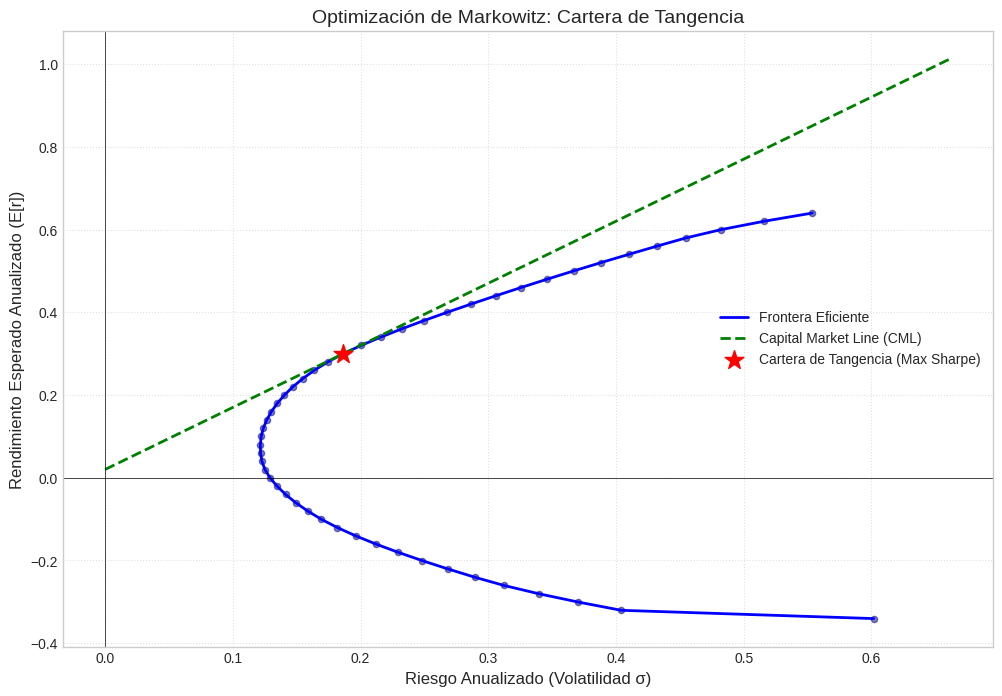

--- CARTERA DE TANGENCIA ---
Rendimiento: 29.97%
Volatilidad: 18.64%
Ratio de Sharpe: 1.50


In [76]:
# =================================================================
# CARTERA DE TANGENCIA Y LÍNEA DEL MERCADO DE CAPITALES (CML)
# =================================================================
import numpy as np
import matplotlib.pyplot as plt

# 1. Definir la Tasa Libre de Riesgo (Risk-Free Rate) - Ej: Bono a 10 años aprox.
rf = 0.02

# 2. Calcular el Ratio de Sharpe para cada cartera de la frontera
# Se calcula sobre 'ef_total' que creamos en los pasos anteriores
ef_total['Sharpe_Ratio'] = (ef_total['Return'] - rf) / ef_total['Volatility']

# 3. Identificar la Cartera de Tangencia (Punto de máximo Sharpe)
optimal_idx = ef_total['Sharpe_Ratio'].idxmax()
tangency_port = ef_total.iloc[optimal_idx]

# 4. Definir los puntos para dibujar la CML
# La línea va desde (0, rf) pasando por el punto de tangencia
x_cml = [0, ef_total['Volatility'].max() * 1.1]
y_cml = [rf, rf + tangency_port['Sharpe_Ratio'] * x_cml[1]]

# 5. Visualización Gráfica
plt.figure(figsize=(12, 8))

# Dibujar la frontera eficiente (Línea azul con puntos)
plt.plot(ef_total['Volatility'], ef_total['Return'], 'b-', linewidth=2, label='Frontera Eficiente')
plt.scatter(ef_total['Volatility'], ef_total['Return'], color='navy', s=20, alpha=0.5)

# Dibujar la Línea del Mercado de Capitales (CML)
plt.plot(x_cml, y_cml, color='green', linestyle='--', linewidth=2, label='Capital Market Line (CML)')

# Resaltar la Cartera de Tangencia (Estrella roja)
plt.scatter(tangency_port['Volatility'], tangency_port['Return'], color='red', s=200,
            marker='*', label='Cartera de Tangencia (Max Sharpe)', zorder=5)

# Configuración estética
plt.title('Optimización de Markowitz: Cartera de Tangencia', fontsize=14)
plt.xlabel('Riesgo Anualizado (Volatilidad σ)', fontsize=12)
plt.ylabel('Rendimiento Esperado Anualizado (E[r])', fontsize=12)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='best')

plt.show()

# --- RESULTADOS POR CONSOLA ---
print(f"--- CARTERA DE TANGENCIA ---")
print(f"Rendimiento: {tangency_port['Return']:.2%}")
print(f"Volatilidad: {tangency_port['Volatility']:.2%}")
print(f"Ratio de Sharpe: {tangency_port['Sharpe_Ratio']:.2f}")

In [77]:
# =================================================================
# ENRIQUECIMIENTO DE LA FRONTERA (ESTRICTO 90 ACTIVOS)
# =================================================================
import pandas as pd
import numpy as np

# 1. Sincronización base: Usamos las columnas de los retornos (que ya son 90)
activos_objetivo = daily_returns.columns.tolist()
assets_master = assets_master_raw.reindex(activos_objetivo).fillna(0)

n_activos = len(assets_master) # Debería ser 90
frontier_enriched_list = []

print(f"Iniciando enriquecimiento para {n_activos} activos...")

for i, row in efficient_frontier.iterrows():
    # Convertimos a array y aplanamos
    weights = np.array(row['Weights']).flatten()

    # --- AJUSTE DE DIMENSIONES (Si hay 91 pesos para 90 activos) ---
    if len(weights) != n_activos:
        # Recortamos el vector de pesos para que coincida con los 90 activos
        weights = weights[:n_activos]
        # Re-normalizamos para que la suma siga siendo exactamente 1 (100%)
        weights = weights / np.sum(weights)

    cartera_stats = {}

    # 2. Cálculo del promedio ponderado (Dot Product)
    # Esto multiplica el Peso_i por el Fundamental_i de cada empresa
    for col in assets_master.columns:
        # Usamos .values para asegurar que solo multiplicamos números
        cartera_stats[f'Avg_{col}'] = np.dot(weights, assets_master[col].values)

    # Guardamos también los pesos ajustados en la lista si fuera necesario
    cartera_stats['Weights_Adjusted'] = weights
    frontier_enriched_list.append(cartera_stats)

# 3. Construcción del DataFrame Final ef_total
df_fund_weighted = pd.DataFrame(frontier_enriched_list)

# Unimos los retornos/riesgo originales con los nuevos fundamentales ponderados
# Eliminamos la columna de pesos vieja y ponemos la ajustada de 90
ef_total = pd.concat([
    efficient_frontier.drop(columns=['Weights']).reset_index(drop=True),
    df_fund_weighted
], axis=1)

# Renombramos para mantener la claridad
ef_total = ef_total.rename(columns={'Weights_Adjusted': 'Weights'})

# 4. Cálculo final del Sharpe Ratio
rf = 0.02
ef_total['Sharpe_Ratio'] = (ef_total['Return'] - rf) / ef_total['Volatility']

print(f"✅ ef_total generado correctamente.")
print(f"Verificación final: {len(ef_total.iloc[0]['Weights'])} activos en cada cartera.")

Iniciando enriquecimiento para 90 activos...
✅ ef_total generado correctamente.
Verificación final: 90 activos en cada cartera.


In [78]:
import re

def motor_chat_pro(frase, df):
    frase = frase.lower()
    # 1. Preparación y Escalas
    df_result = df.sort_values('Volatility').reset_index(drop=True)
    n = len(df_result)

    escalas = {
        'bajo': (0, int(n*0.2)),
        'medio-bajo': (int(n*0.2), int(n*0.4)),
        'medio': (int(n*0.4), int(n*0.6)),
        'medio-alto': (int(n*0.6), int(n*0.8)),
        'alto': (int(n*0.8), n)
    }

    mapeo = {
        'net income': ['beneficio', 'net income', 'ganancia'],
        'total revenue': ['ventas', 'revenue', 'ingresos'],
        'ebitda': ['ebitda'],
        'free cash flow': ['cash flow', 'fcf', 'flujo de caja'],
        'total debt': ['deuda', 'debt'],
        'total assets': ['activos', 'assets'],
        'roe': ['roe', 'rentabilidad capital'],
        'roa': ['roa', 'rentabilidad activos'],
        'yield': ['dividendo', 'yield']
    }

    criterios_detectados = []

    # --- DETECCIÓN 1: Riesgo ---
    for k in escalas.keys():
        if k in frase:
            criterios_detectados.append(('riesgo', k))
            break

    # --- DETECCIÓN 2, 3 y 4: Métricas ---
    numeros = [float(s) for s in re.findall(r"[-+]?\d*\.\d+|\d+", frase)]
    idx_num = 0
    palabras = frase.split()

    for word in palabras:
        for metrica, sinonimos in mapeo.items():
            if any(s in word for s in sinonimos) and idx_num < len(numeros):
                col = 'Avg_' + metrica
                if 'crecimiento' in frase or 'variacion' in frase: col += '_Growth'
                elif '2024' in frase: col += ' 2024'
                elif '2023' in frase: col += ' 2023'

                if 'roe' in word: col = 'Avg_ROE % 2024'
                if 'yield' in word or 'dividendo' in word: col = 'Avg_Yield 31/12/2024 (%)'

                criterios_detectados.append((col, numeros[idx_num]))
                idx_num += 1
                break
        if len(criterios_detectados) >= 4: break

    # --- FILTRADO EN CASCADA CON PROXIMIDAD ---
    for crit, val in criterios_detectados:
        temp_df = pd.DataFrame()
        if crit == 'riesgo':
            start, end = escalas[val]
            temp_df = df_result.iloc[start:end]
        else:
            if crit in df_result.columns:
                temp_df = df_result[df_result[crit] >= val]

        if not temp_df.empty:
            df_result = temp_df
        else:
            # LÓGICA DE PROXIMIDAD: Si nadie cumple, cogemos los que más se acercan
            if crit in df_result.columns:
                df_result = df_result.sort_values(crit, ascending=False).head(5)

    # Sharpe para elegir la mejor de las finalistas
    df_result['Sharpe'] = df_result['Return'] / df_result['Volatility']
    cartera_final = df_result.sort_values('Sharpe', ascending=False).iloc[0]

    return cartera_final, criterios_detectados

In [79]:
# --- TU CONSULTA AQUÍ ---
pregunta = "quiero riesgo medio-alto, con unos assets que crezcan más del 10% al año, que de un dividendo de al menos 0,5% y que reduzca su deuda al menos un 5% al año"

cartera, log = motor_chat_pro(pregunta, ef_total)

print("="*50)
print("📌 TICKET DE SELECCIÓN DE CARTERA")
print("="*50)
print(f"JERARQUÍA DE FILTROS:")
for i, (c, v) in enumerate(log):
    print(f"  {i+1}. {c} >= {v}")

print("-"*50)
print(f"DESEMPEÑO DE LA CARTERA:")
print(f"  📈 Retorno Esperado: {cartera['Return']:.2%}")
print(f"  📉 Riesgo (Volatilidad): {cartera['Volatility']:.2%}")
print(f"  ⚖️ Ratio de Sharpe: {cartera['Sharpe']:.2f}")

print("-"*50)
print(f"VALORES FUNDAMENTALES (Promedio Ponderado):")
print(f"  • ROE: {cartera.get('Avg_ROE % 2024', 0):.2f}%")
print(f"  • Dividend Yield: {cartera.get('Avg_Yield 31/12/2024 (%)', 0):.2f}%")
print(f"  • Crecimiento NI: {cartera.get('Avg_Net Income_Growth', 0):.2f}%")
print("="*50)

# Ver composición
pesos_finales = pd.DataFrame({'Ticker': portfolio, 'Peso': cartera['Weights']})
print("\nPRINCIPALES POSICIONES:")
display(pesos_finales[pesos_finales['Peso'] > 0.01].sort_values('Peso', ascending=False))

📌 TICKET DE SELECCIÓN DE CARTERA
JERARQUÍA DE FILTROS:
  1. riesgo >= medio
  2. Avg_total assets >= 10.0
  3. Avg_Yield 31/12/2024 (%) >= 0.0
  4. Avg_total debt >= 5.0
--------------------------------------------------
DESEMPEÑO DE LA CARTERA:
  📈 Retorno Esperado: 29.97%
  📉 Riesgo (Volatilidad): 18.64%
  ⚖️ Ratio de Sharpe: 1.61
--------------------------------------------------
VALORES FUNDAMENTALES (Promedio Ponderado):
  • ROE: -14.69%
  • Dividend Yield: 0.24%
  • Crecimiento NI: 72.44%

PRINCIPALES POSICIONES:


,Ticker,Peso
76,TTWO,0.235133
30,REGN,0.164390
9,COST,0.156077
62,DXCM,0.128744
28,BKNG,0.104076
5,META,0.103991
22,INTU,0.090126
29,FISV,0.017461
